# Imports and Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from rl_env.pendulum_env import CustomInvertedPendulum


# Initialize the Environment and Print Initial State

In [3]:
env = CustomInvertedPendulum(torque_penalty=0.001)
initial_state = env.reset()

print("Initial angle (rad):", initial_state[0])
print("Initial angular velocity (rad/s):", initial_state[1])


Initial angle (rad): -2.4674011176767743
Initial angular velocity (rad/s): -0.04402978161818005


# Simulate One Run with Random Actions

In [4]:
states = []
rewards = []
actions = []

state = env.reset()

for t in range(200):
    action = np.random.uniform(-2, 2)
    next_state, reward, done = env.step(action)

    states.append(state)
    actions.append(action)
    rewards.append(reward)

    state = next_state

## Note: Damping in the Environment

In real physical systems, motion doesn't go on forever — **energy is lost over time** due to air resistance, friction, etc.  
To simulate this, we apply a **damping factor** to the pendulum's angular velocity after each step:

```python
self.dot_omega *= self.damping  # e.g. damping = 0.99


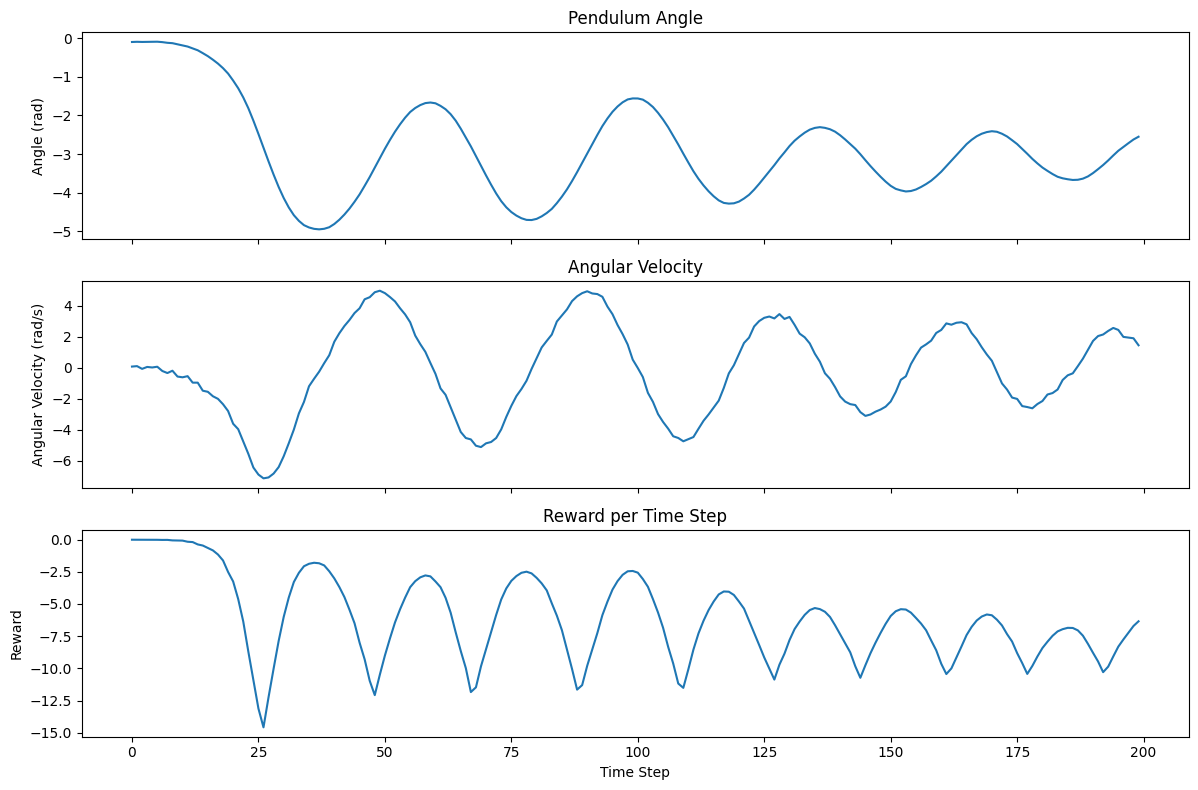

In [5]:
# Convert to numpy arrays for easy plotting
states = np.array(states)
angles = states[:, 0]
angular_velocities = states[:, 1]
rewards = np.array(rewards)

# Plot state and reward evolution
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axs[0].plot(angles)
axs[0].set_ylabel("Angle (rad)")
axs[0].set_title("Pendulum Angle")

axs[1].plot(angular_velocities)
axs[1].set_ylabel("Angular Velocity (rad/s)")
axs[1].set_title("Angular Velocity")

axs[2].plot(rewards)
axs[2].set_ylabel("Reward")
axs[2].set_title("Reward per Time Step")
axs[2].set_xlabel("Time Step")

plt.tight_layout()
plt.show()


## Animate Random Run

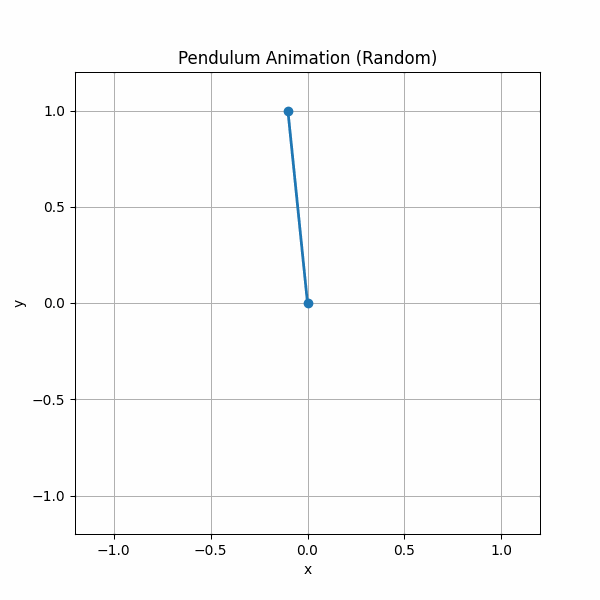

In [6]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image

L = env.L
x = L * np.sin(angles)
y = L * np.cos(angles)

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-L - 0.2, L + 0.2)
ax.set_ylim(-L - 0.2, L + 0.2)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True)
ax.set_title("Pendulum Animation (Random)")
line, = ax.plot([], [], 'o-', lw=2)

def init():
    line.set_data([], [])
    return line,

def update(i):
    line.set_data([0, x[i]], [0, y[i]])
    return line,

ani_random = animation.FuncAnimation(fig, update, frames=len(x), init_func=init,
                                     interval=30, blit=True)

ani_random.save("../figs/pendulum_random.gif", writer='pillow', fps=30)
plt.close()
Image(filename="../figs/pendulum_random.gif")


# Visualize Angle Normalization

To ensure consistent evaluation of the pendulum's position, the angle `ω` is normalized to lie within the range **[-π, π]**


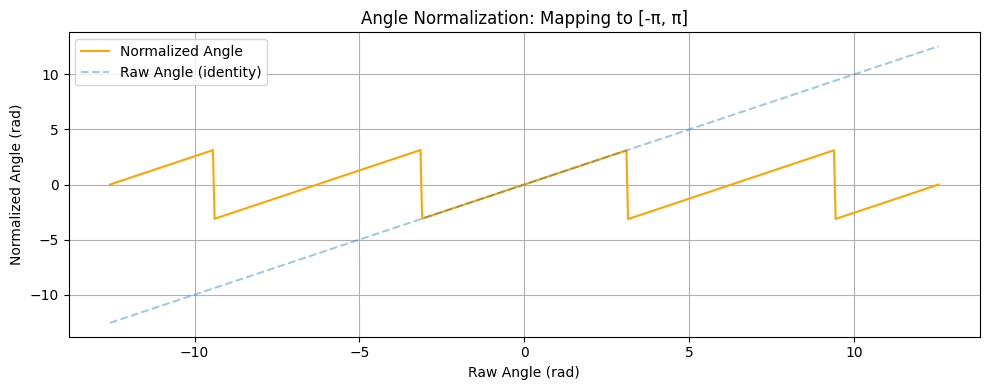

In [7]:
# Generate raw angles from -4π to 4π
raw_angles = np.linspace(-4 * np.pi, 4 * np.pi, 500)
normalized_angles = (raw_angles + np.pi) % (2 * np.pi) - np.pi

# Plot raw vs. normalized
plt.figure(figsize=(10, 4))
plt.plot(raw_angles, normalized_angles, label='Normalized Angle', color='orange')
plt.plot(raw_angles, raw_angles, linestyle='--', label='Raw Angle (identity)', alpha=0.4)
plt.xlabel("Raw Angle (rad)")
plt.ylabel("Normalized Angle (rad)")
plt.title("Angle Normalization: Mapping to [-π, π]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Reward Function

The environment rewards the pendulum for staying upright, moving smoothly, and avoiding large torque values.

The reward at each step is computed as:

```python
reward = - (omega_normalized**2 + 0.1 * dot_omega**2 + 0.001 * action**2)


## Reward Heatmap

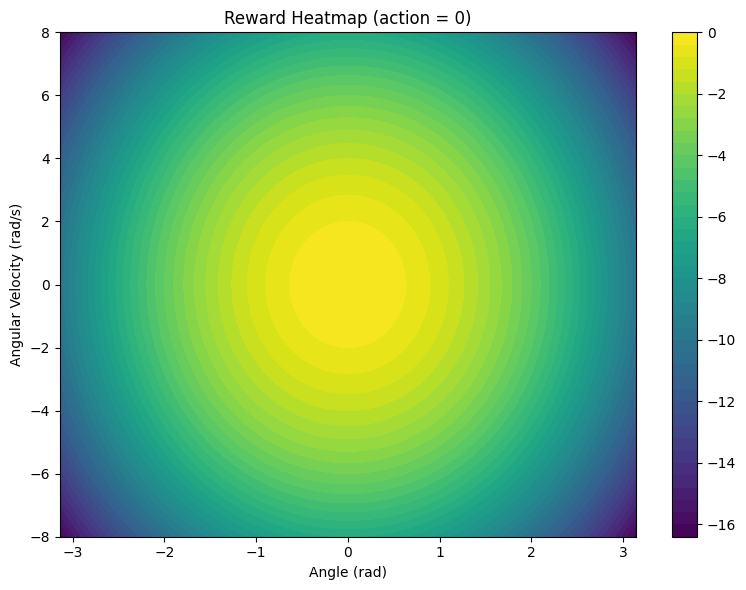

In [8]:
# Create a grid of angle and angular velocity values
angle_vals = np.linspace(-np.pi, np.pi, 100)
vel_vals = np.linspace(-8, 8, 100)
A, V = np.meshgrid(angle_vals, vel_vals)

# Compute reward at each (angle, velocity) with zero torque
R = -((A)**2 + 0.1 * V**2 + 0.001 * 0.0**2)  # a=0

plt.figure(figsize=(8, 6))
heatmap = plt.contourf(A, V, R, levels=50, cmap='viridis')
plt.colorbar(heatmap)
plt.title("Reward Heatmap (action = 0)")
plt.xlabel("Angle (rad)")
plt.ylabel("Angular Velocity (rad/s)")
plt.tight_layout()
plt.show()


# Example Controller

This is a handcrafted **Proportional-Derivative (PD) controller** used to stabilize the pendulum without learning. It's based on a classic control approach:

```python
a = -Kp * sin(angle) - Kd * angular_velocity


In [9]:
Kp = 2.0
Kd = 0.5

env = CustomInvertedPendulum()
state = env.reset()

states = []
actions = []
rewards = []

for t in range(200):
    angle = state[0]
    angular_velocity = state[1]
    
    action = -Kp * np.sin(angle) - Kd * angular_velocity
    next_state, reward, done = env.step(action)

    states.append(state)
    actions.append(action)
    rewards.append(reward)

    state = next_state


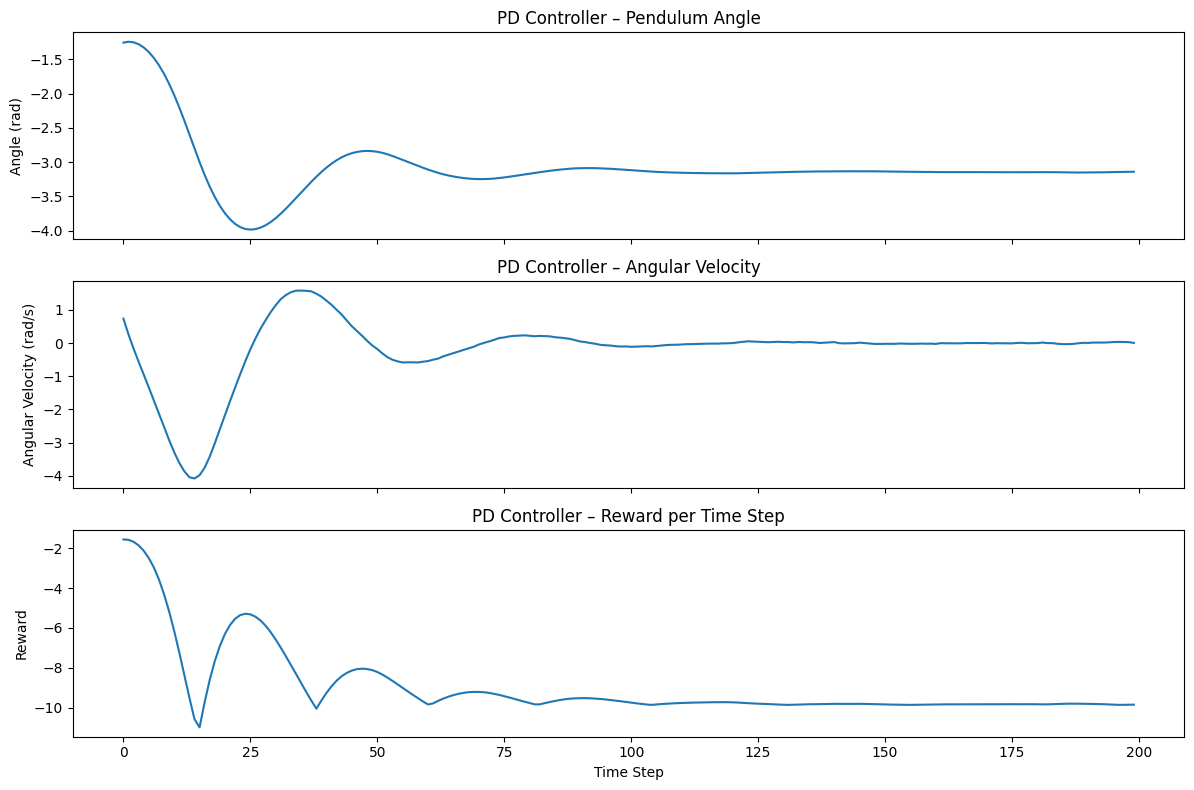

In [10]:
states = np.array(states)
angles = states[:, 0]
angular_velocities = states[:, 1]
rewards = np.array(rewards)

fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axs[0].plot(angles)
axs[0].set_ylabel("Angle (rad)")
axs[0].set_title("PD Controller – Pendulum Angle")

axs[1].plot(angular_velocities)
axs[1].set_ylabel("Angular Velocity (rad/s)")
axs[1].set_title("PD Controller – Angular Velocity")

axs[2].plot(rewards)
axs[2].set_ylabel("Reward")
axs[2].set_title("PD Controller – Reward per Time Step")
axs[2].set_xlabel("Time Step")

plt.tight_layout()
plt.show()


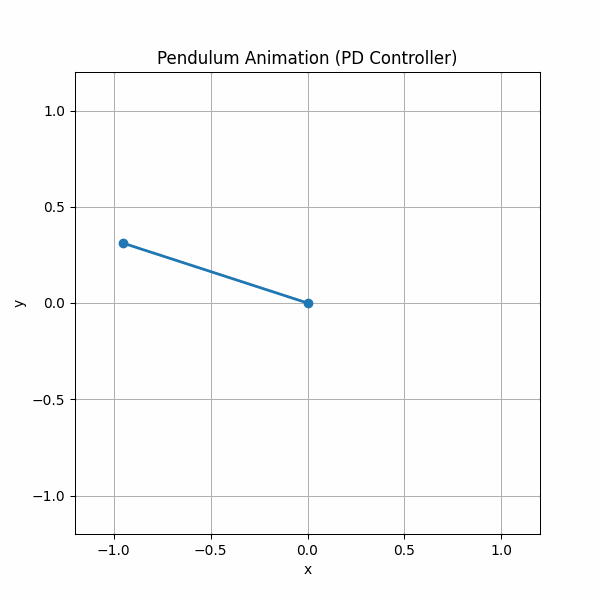

In [11]:

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image

L = env.L
x = L * np.sin(angles)
y = L * np.cos(angles)

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-L - 0.2, L + 0.2)
ax.set_ylim(-L - 0.2, L + 0.2)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True)
ax.set_title("Pendulum Animation (PD Controller)")
line, = ax.plot([], [], 'o-', lw=2)

def init():
    line.set_data([], [])
    return line,

def update(i):
    line.set_data([0, x[i]], [0, y[i]])
    return line,

ani_random = animation.FuncAnimation(fig, update, frames=len(x), init_func=init,
                                     interval=30, blit=True)

ani_random.save("../figs/pendulum_pd_controller.gif", writer='pillow', fps=30)
plt.close()
Image(filename="../figs/pendulum_pd_controller.gif")


![pendulum_pd_controller](pendulum_pd_controller.gif)

## Analysis of PD Controller

While the PD controller is simple and effective at **dampening the motion** of the pendulum, it does not contain any mechanism for **swinging the pendulum upward**. Its only objective is to apply a torque that reduces the current angle and angular velocity, assuming the goal is to return to the bottom.


This behavior is a good example of how a learned policy — especially in the early stages of training — might converge to a **local maximum**:

- **Being at the bottom** avoids high penalties from angular velocity or large torques.
- It's a **low-energy state** that satisfies the reward function better than chaotic motion.
- However, it's **not the global optimum**: maximum reward occurs when the pendulum is upright and still.

Without exploration (or proper shaping of rewards and environment), the agent may "learn" to **do nothing** because it's safer than trying to swing up and potentially getting penalized.
